In [1]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
import time
import torch
from pytorchtools import EarlyStopping
import math
import numpy as np

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SWong7923\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
reviews = pd.read_csv('\\Users\\SWong7923\\PycharmProjects\\pythonProject2\\archive\\Reviews.csv')

In [4]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [5]:
reviews.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
reviews.shape

(568454, 10)

In [7]:
reviews.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [8]:
# reviews['Summary'].replace('',np.nan,inplace=True)
reviews.dropna(subset=['Summary', 'Text'],inplace=True)

In [9]:
reviews.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                    0
Text                       0
dtype: int64

In [10]:
reviews.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [11]:
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are",
' american ':
        [
            'amerikan'
        ],

    ' adolf ':
        [
            'adolf'
        ],


    ' hitler ':
        [
            'hitler'
        ],

    ' fuck':
        [
            '(f)(u|[^a-z0-9 ])(c|[^a-z0-9 ])(k|[^a-z0-9 ])([^ ])*',
            '(f)([^a-z]*)(u)([^a-z]*)(c)([^a-z]*)(k)',
            ' f[!@#\$%\^\&\*]*u[!@#\$%\^&\*]*k', 'f u u c',
            '(f)(c|[^a-z ])(u|[^a-z ])(k)', r'f\*',
            'feck ', ' fux ', 'f\*\*', 
            'f\-ing', 'f\.u\.', 'f###', ' fu ', 'f@ck', 'f u c k', 'f uck', 'f ck','fuk', 'wtf','fucck','f cking'
        ],

    ' ass ':
        [
            '[^a-z]ass ', '[^a-z]azz ', 'arrse', ' arse ', '@\$\$'
                                                           '[^a-z]anus', ' a\*s\*s', '[^a-z]ass[^a-z ]',
            'a[@#\$%\^&\*][@#\$%\^&\*]', '[^a-z]anal ', 'a s s'
        ],

    ' asshole ':
        [
            ' a[s|z]*wipe', 'a[s|z]*[w]*h[o|0]+[l]*e', '@\$\$hole', 'ass hole'
        ],

    ' bitch ':
        [
            'b[w]*i[t]*ch', 'b!tch',
            'bi\+ch', 'b!\+ch', '(b)([^a-z]*)(i)([^a-z]*)(t)([^a-z]*)(c)([^a-z]*)(h)',
            'biatch', 'bi\*\*h', 'bytch', 'b i t c h','beetch'
        ],

    ' bastard ':
        [
            'ba[s|z]+t[e|a]+rd'
        ],

    ' transgender':
        [
            'transgender','trans gender'
        ],

    ' gay ':
        [
            'gay'
        ],

    ' cock ':
        [
            '[^a-z]cock', 'c0ck', '[^a-z]cok ', 'c0k', '[^a-z]cok[^aeiou]', ' cawk',
            '(c)([^a-z ])(o)([^a-z ]*)(c)([^a-z ]*)(k)', 'c o c k'
        ],

    ' dick ':
        [
            ' dick[^aeiou]', 'deek', 'd i c k','diick '
        ],

    ' suck ':
        [
            'sucker', '(s)([^a-z ]*)(u)([^a-z ]*)(c)([^a-z ]*)(k)', 'sucks', '5uck', 's u c k'
        ],

    ' cunt ':
        [
            'cunt', 'c u n t'
        ],

    ' bullshit ':
        [
            'bullsh\*t', 'bull\$hit','bs'
        ],

    ' homosexual':
        [
            'homo sexual','homosex'
        ],

    ' jerk ':
        [
            'jerk'
        ],

    ' idiot ':
        [
            'i[d]+io[t]+', '(i)([^a-z ]*)(d)([^a-z ]*)(i)([^a-z ]*)(o)([^a-z ]*)(t)', 'idiots', 'i d i o t'
        ],

    ' dumb ':
        [
            '(d)([^a-z ]*)(u)([^a-z ]*)(m)([^a-z ]*)(b)'
        ],

    ' shit ':
        [
            'shitty', '(s)([^a-z ]*)(h)([^a-z ]*)(i)([^a-z ]*)(t)', 'shite', '\$hit', 's h i t'
        ],

    ' shithole ':
        [
            'shythole','shit hole'
        ],

    ' retard ':
        [
            'returd', 'retad', 'retard', 'wiktard', 'wikitud'
        ],

    ' rape ':
        [
            ' raped'
        ],

    ' dumbass':
        [
            'dumb ass', 'dubass'
        ],

    ' asshead':
        [
            'butthead', 'ass head'
        ],

    ' sex ':
        [
            's3x', 'sexuality',
        ],


    ' nigger ':
        [
            'nigger', 'ni[g]+a', ' nigr ', 'negrito', 'niguh', 'n3gr', 'n i g g e r'
        ],

    ' shut the fuck up':
        [
            'stfu'
        ],

    ' pussy ':
        [
            'pussy[^c]', 'pusy', 'pussi[^l]', 'pusses'
        ],

    ' faggot ':
        [
            'faggot', ' fa[g]+[s]*[^a-z ]', 'fagot', 'f a g g o t', 'faggit',
            '(f)([^a-z ]*)(a)([^a-z ]*)([g]+)([^a-z ]*)(o)([^a-z ]*)(t)', 'fau[g]+ot', 'fae[g]+ot',
        ],

    ' motherfucker':
        [
            ' motha ', ' motha f', ' mother f', 'motherucker', 'mother fucker'
        ],

    ' whore ':
        [
            'wh\*\*\*', 'w h o r e'
        ],
    " White's " : 'white'
}

In [12]:
def clean_text(text, remove_stopwords = True):
    '''Remove unwanted characters, stopwords, and format the text to create fewer nulls word embeddings'''
    
    # Convert words to lower case
    text = text.lower()
    
    # Replace contractions with their longer forms 
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
    
    # Format words and remove unwanted characters
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'<br >', '', text)
    text = re.sub(r'\'', ' ', text)
    
    # Optionally, remove stop words
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    return text

In [13]:
clean_summaries = []
for summary in reviews.Summary:
    if not isinstance(summary, str):
        print(summary)
        continue
    clean_summaries.append(clean_text(summary, remove_stopwords=False))
print("Summaries are complete.")

clean_texts = []
for text in reviews.Text:
    clean_texts.append(clean_text(text))
print("Texts are complete.")

Summaries are complete.
Texts are complete.


In [14]:
# Inspect the cleaned summaries and texts to ensure they have been cleaned well
for i in range(15,20):
    print("Clean Review #",i+1)
    print("Summary: ",clean_summaries[i])
    print("Content: ",clean_texts[i])
    print()

Clean Review # 16
Summary:  lots of twizzlers  just what you expect 
Content:  daughter loves twizzlers shipment six pounds really hit spot exactly would expect six packages strawberry twizzlers

Clean Review # 17
Summary:  poor taste
Content:  love eating good watching tv looking movies sweet like transfer zip lock baggie stay fresh take time eating

Clean Review # 18
Summary:  love it 
Content:  satisfied twizzler purchase shared others enjoyed definitely ordering

Clean Review # 19
Summary:  great sweet candy 
Content:  twizzlers strawberry childhood favorite candy made lancaster pennsylvania candies inc one oldest confectionery firms united states subsidiary hershey company company established 1845 young smylie also make apple licorice twists green color blue raspberry licorice twists like all<br ><br >i keep dry cool place recommended put fridge according guinness book records longest licorice twist ever made measured 1 200 feet 370 weighted 100 pounds 45 kg made candies inc recor

In [15]:
def count_words(count_dict, text):
    '''Count the number of occurrences of each word in a set of text'''
    for sentence in text:
        for word in sentence.split():
            if word not in count_dict:
                count_dict[word] = 1
            else:
                count_dict[word] += 1

In [16]:
word_counts = {}

count_words(word_counts, clean_summaries)
count_words(word_counts, clean_texts)
            
print("Size of Vocabulary:", len(word_counts))

Size of Vocabulary: 132887


In [17]:
embeddings_index = {}
with open('\\Users\\SWong7923\\PycharmProjects\\pythonProject2\\archive\\numberbatch-en.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split(' ')
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = embedding
print('Word embeddings:', len(embeddings_index))

Word embeddings: 417195


In [18]:
# Find the number of words that are missing from CN, and are used more than our threshold.
missing_words = 0
threshold = 20

for word, count in word_counts.items():
    if count > threshold:
        if word not in embeddings_index:
            missing_words += 1
            
missing_ratio = round(missing_words/len(word_counts),4)*100
            
print("Number of words missing from CN:", missing_words)
print("Percent of words that are missing from vocabulary: {}%".format(missing_ratio))

Number of words missing from CN: 3870
Percent of words that are missing from vocabulary: 2.91%


In [19]:
# Limit the vocab that we will use to words that appear ≥ threshold or are in GloVe

#dictionary to convert words to integers
vocab_to_int = {} 

value = 0
for word, count in word_counts.items():
    if count >= threshold or word in embeddings_index:
        vocab_to_int[word] = value
        value += 1

# Special tokens that will be added to our vocab
codes = ["<UNK>","<PAD>","<EOS>","<GO>"]   

# Add codes to vocab
for code in codes:
    vocab_to_int[code] = len(vocab_to_int)

# Dictionary to convert integers to words
int_to_vocab = {}
for word, value in vocab_to_int.items():
    int_to_vocab[value] = word

usage_ratio = round(len(vocab_to_int) / len(word_counts),4)*100

print("Total number of unique words:", len(word_counts))
print("Number of words we will use:", len(vocab_to_int))
print("Percent of words we will use: {}%".format(usage_ratio))

Total number of unique words: 132887
Number of words we will use: 59595
Percent of words we will use: 44.85%


In [20]:
# Need to use 300 for embedding dimensions to match CN's vectors.
embedding_dim = 300
nb_words = len(vocab_to_int)

# Create matrix with default values of zero
word_embedding_matrix = np.zeros((nb_words, embedding_dim), dtype=np.float32)
for word, i in vocab_to_int.items():
    if word in embeddings_index:
        word_embedding_matrix[i] = embeddings_index[word]
    else:
        # If word not in CN, create a random embedding for it
        new_embedding = np.array(np.random.uniform(-1.0, 1.0, embedding_dim))
        embeddings_index[word] = new_embedding
        word_embedding_matrix[i] = new_embedding

# Check if value matches len(vocab_to_int)
print(len(word_embedding_matrix))

59595


In [21]:
def convert_to_ints(text, word_count, unk_count):
    '''Convert words in text to an integer(the index of words in vocabulary).
       If word is not in vocab_to_int, use UNK's integer.
       Total the number of words and UNKs.
       Add EOS token to the end of texts'''
    ints = []
    for sentence in text:
        sentence_ints = [vocab_to_int["<GO>"]]
        for word in sentence.split():
            word_count += 1
            if word in vocab_to_int:
                sentence_ints.append(vocab_to_int[word])
            else:
                sentence_ints.append(vocab_to_int["<UNK>"])
                unk_count += 1
       
        sentence_ints.append(vocab_to_int["<EOS>"])
        ints.append(sentence_ints)
    return ints, word_count, unk_count

In [22]:
# Apply convert_to_ints to clean_summaries and clean_texts
word_count = 0
unk_count = 0

int_summaries, word_count, unk_count = convert_to_ints(clean_summaries, word_count, unk_count)
int_texts, word_count, unk_count = convert_to_ints(clean_texts, word_count, unk_count)

unk_percent = round(unk_count/word_count,4)*100

print("Total number of words in headlines:", word_count)
print("Total number of UNKs in headlines:", unk_count)
print("Percent of words that are UNK: {}%".format(unk_percent))

Total number of words in headlines: 25680389
Total number of UNKs in headlines: 192248
Percent of words that are UNK: 0.75%


In [23]:
def create_lengths(text):
    '''Create a data frame of the sentence lengths from a text'''
    lengths = []
    for sentence in text:
        lengths.append(len(sentence))
    return pd.DataFrame(lengths, columns=['counts'])

In [24]:
lengths_summaries = create_lengths(int_summaries)
lengths_texts = create_lengths(int_texts)

print("Summaries:")
print(lengths_summaries.describe())
print()
print("Texts:")
print(lengths_texts.describe())

Summaries:
              counts
count  568427.000000
mean        6.181613
std         2.657912
min         2.000000
25%         4.000000
50%         6.000000
75%         7.000000
max        50.000000

Texts:
              counts
count  568427.000000
mean       42.996376
std        42.520534
min         2.000000
25%        19.000000
50%        30.000000
75%        51.000000
max      2086.000000


In [25]:
# Inspect the length of texts
print(np.percentile(lengths_texts.counts, 90))
print(np.percentile(lengths_texts.counts, 95))
print(np.percentile(lengths_texts.counts, 99))

85.0
116.0
208.0


In [26]:
# Inspect the length of summaries
print(np.percentile(lengths_summaries.counts, 90))
print(np.percentile(lengths_summaries.counts, 95))
print(np.percentile(lengths_summaries.counts, 99))

10.0
11.0
15.0


In [27]:
def unk_counter(sentence):
    '''Counts the number of time UNK appears in a sentence.'''
    unk_count = 0
    for word in sentence:
        if word == vocab_to_int["<UNK>"]:
            unk_count += 1
    return unk_count

In [28]:
# takes a long time  , this is normal

# Sort the summaries and texts by the length of the texts, shortest to longest
# Limit the length of summaries and texts based on the min and max ranges.
# Remove reviews that include too many UNKs

sorted_summaries = []
sorted_texts = []
max_text_length = 84
max_summary_length = 13
min_length = 2
unk_text_limit = 1
unk_summary_limit = 0

for length in range(min(lengths_texts.counts), max_text_length): 
    for count, words in enumerate(int_summaries):
        if (len(int_summaries[count]) >= min_length and
            len(int_summaries[count]) <= max_summary_length and
            len(int_texts[count]) >= min_length and
            unk_counter(int_summaries[count]) <= unk_summary_limit and
            unk_counter(int_texts[count]) <= unk_text_limit and
            length == len(int_texts[count])
           ):
            sorted_summaries.append(int_summaries[count])
            sorted_texts.append(int_texts[count])
        
# Compare lengths to ensure they match
print(len(sorted_summaries))
print(len(sorted_texts))

472193
472193


In [29]:
#sorted_texts[-100:-1]

In [30]:
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch
import torch.nn.utils.rnn as rnn_utils
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
from torchvision.utils import make_grid
import torch.nn as nn
import matplotlib.pyplot as plt
import random 

In [31]:
# Subset the data for training
start = 200000
end = start + 300000
sorted_summaries_short = sorted_summaries[start:end]
sorted_texts_short = sorted_texts[start:end]
print("The shortest text length:", len(sorted_texts_short[0]))
print("The longest text length:",len(sorted_texts_short[-1]))

The shortest text length: 24
The longest text length: 83


In [32]:
" ".join([int_to_vocab[i] for i in sorted_texts_short[2]])

'<GO> usually buy go go brown rice convenience time cook use rice noticeable change pleasing smell taste hybrid rice love high quality rice <EOS>'

In [33]:
train_size = int(len(sorted_texts_short) * 0.9)
val_size = len(sorted_texts_short) - train_size
zipped = list(zip(sorted_texts_short, sorted_summaries_short))
train_dataset, val_dataset = torch.utils.data.random_split(zipped, [train_size,val_size])
text_train, summ_train = zip(*train_dataset)
text_val, summ_val = zip(*val_dataset)


In [34]:
" ".join([int_to_vocab[i] for i in summ_train[3]])

'<GO> chewy seaweed <EOS>'

In [35]:
" ".join([int_to_vocab[i] for i in text_train[3]])

'<GO> usually buy trader joe brand love brand crispy much softer snack kids eat car actually less messy find quite tasty kids love first tried thought maybe moisture leaked opening jars realised different texture definitely grew <EOS>'

In [36]:
[len(x)for x in text_train[:10]]

[63, 24, 33, 37, 36, 27, 67, 28, 36, 32]

In [37]:
def len_argsort(seq):
    return sorted(range(len(seq)), key=lambda x: len(seq[x]))

In [38]:
sorted_index = len_argsort(text_train)
text_train = [text_train[i] for i in sorted_index]
summ_train = [summ_train[i] for i in sorted_index]

In [39]:
[len(x)for x in text_train[-2:-1]] # 24 - 83

[83]

In [40]:
k = 2
print(" ".join([int_to_vocab[i] for i in text_train[k]]))
print(" ".join([int_to_vocab[i] for i in summ_train[k]]))

<GO> dog would anything liver treats whenever playmates walk drag owners house liver treat well fact owners buy healthy great training treat love <EOS>
<GO> dogs love it plus it is healthy <EOS>


In [41]:
# 按索引划分batch，返回的每个batch中存的是index
def get_minibatches(n, minibatch_size, shuffle=True):
    idx_list = np.arange(0, n, minibatch_size)
    if shuffle:
        np.random.shuffle(idx_list)
    minibatches = []
    for idx in idx_list:
        minibatches.append(np.arange(idx, min(idx+minibatch_size, n)))
    return minibatches      # 这个会返回多批连着的bath_size个索引  
#get_minibatches(len(train_en), 32)

# 这个函数是在做数据预处理， 由于每个句子都不是一样长， 所以通过这个函数就可以把句子进行补齐， 不够长的在句子后面添加0
def prepare_data(seqs):
    lengths = [len(seq) for seq in seqs]    # 得到每个句子的长度
    n_samples = len(seqs)       # 得到一共有多少个句子
    max_len = np.max(lengths)              # 找出最大的句子长度
    
    x = np.zeros((n_samples, max_len)).astype('int32')    # 按照最大句子长度生成全0矩阵
    x_lengths = np.array(lengths).astype('int32')
    for idx, seq in enumerate(seqs):        # 把有句子的位置填充进去
        x[idx, :lengths[idx]] = seq
    return x, x_lengths      # x_mask

def gen_examples(en_sentences, cn_sentences, batch_size):
    minibatches = get_minibatches(len(en_sentences), batch_size)   # 得到batch个索引
    all_ex = []
    for minibatch in minibatches:   # 每批数据的索引
        mb_en_sentences = [en_sentences[t] for t in minibatch]   # 取数据
        mb_cn_sentences = [cn_sentences[t] for t in minibatch]  # 取数据
        mb_x, mb_x_len = prepare_data(mb_en_sentences) # 填充成一样的长度， 但是要记录一下句子的真实长度， 这个在后面输入网络的时候得用
        mb_y, mb_y_len = prepare_data(mb_cn_sentences)
        all_ex.append((mb_x, mb_x_len, mb_y, mb_y_len))
    return all_ex

batch_size = 64
train_data = gen_examples(text_train, summ_train, batch_size)   # 产生训练集
random.shuffle(train_data)
dev_data = gen_examples(text_val, summ_val, batch_size)   # 产生验证集


In [42]:
print(train_data[1][0].shape, train_data[1][1].shape, train_data[1][2].shape, train_data[1][3].shape)  

(64, 43) (64,) (64, 12) (64,)


In [43]:
class PlainEncoder(nn.Module):
    def __init__(self, vocab_size, hidden_size, dropout=0.2):
        super(PlainEncoder, self).__init__()
        self.embed = nn.Embedding(vocab_size, hidden_size)
        self.rnn = nn.GRU(hidden_size, hidden_size, batch_first=True)   # embedding layer最后输出的维度是hidden_size,相当于现在每个词的embedding维度等于hidden_size
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, lengths):  
        # 这里需要输入lengths， 因为每个句子是不一样长的，我们需要每个句子最后一个时间步的隐藏状态,所以需要知道句子有多长， x表示一个batch里面的句子 
        # 这里的x lengths 都是tensor， 调用tensor.sort, 返回的是排好的数组和index
        # 把batch里面的seq按照长度排序  
        sorted_len, sorted_idx = lengths.sort(0, descending=True)  #d_le sorted_len表示排好序的数组， sorted_index表示每个元素在原数组位置
        x_sorted = x[sorted_idx.long()]  # 将句子已经按照sorted_idx排序
        embedded = self.dropout(self.embed(x_sorted))   # [batch_size, seq_len, embed_size]
        #得到embedding， 每个句子的embedding维度等于hidden_size
        # 下面一段代码处理变长序列
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, sorted_len.long().cpu().data.numpy(), batch_first=True)    # 这里的data.numpy()是原来张量的克隆， 然后转成了numpy数组， 相当于clone().numpy()
        # 上面这句话之后， 会把变长序列的0都给去掉， 之前填充的字符都给压扁
        packed_out, hid = self.rnn(packed_embedded)    # 当输入为packed_embedding时，句子有多长，hidden state就有多长
        out, _ = nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True) # 将out再填充回去，便于后续处理（实际上后面直接抛弃了，有用的只是最后一个字的hidden state） 
        _, original_idx = sorted_idx.sort(0, descending=False)      # 恢复原来的顺序
        out = out[original_idx.long()].contiguous()  # 深拷贝rnn输出的tensor
        hid = hid[:, original_idx.long()].contiguous() 
        
        return out, hid[[-1]]   # 把最后一层的hid给拿出来  

In [44]:
class PlainDecoder(nn.Module):
    def __init__(self, vocab_size, hidden_size, dropout=0.2):
        super(PlainDecoder, self).__init__()
        self.embed = nn.Embedding(vocab_size, hidden_size)
        self.rnn = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, y, y_lengths, hid):
        # y: [batch_size, y_length] y_length是最长句子的长度（每个句子都被padding成了这么长）
        # hid是encoder得到的最后一个字的hidden_state， 实际上包含了整个输入序列的信息
        sorted_len, sorted_idx = y_lengths.sort(0, descending=True)    # 依然是句子从长到短排序

        y_sorted = y[sorted_idx.long()] # 排序过程
        hid = hid[:, sorted_idx.long()] # 排序过程
        
        y_sorted = self.dropout(self.embed(y_sorted)) # batch_size, y_length, embed_size] 这里的embed_size实际上是等于hidden_size的
        
        pack_seq = nn.utils.rnn.pack_padded_sequence(y_sorted, sorted_len.long().cpu().data.numpy(), batch_first=True)
        out, hid = self.rnn(pack_seq, hid)   # decoder里面的初始state 就是encoder中得到的最后一个字的state
        unpacked, _ = nn.utils.rnn.pad_packed_sequence(out, batch_first=True)   # [batch, y_length, hidden_size] 恢复out的长度，（实际上是把packed_sequence 转回tensor）
        _, original_idx = sorted_idx.sort(0, descending=False) #恢复原来的句子顺序
        output_seq = unpacked[original_idx.long()].contiguous()  # [batch, y_length, hidden_size] 恢复顺序+深拷贝
        
        hid = hid[:, original_idx.long()].contiguous()   # [1， batch, hidden_size] decoder的hid_state其实没用，只需要输出即可。
        output = F.log_softmax(self.out(output_seq), -1)    
        #   self.out 是一个fully connected neural network,输出结果是[batch, y_length, vocab_size] 然后对最后一个维度 vocab_size进行归一化,那么现在output的每一步输出，都是一个vocab_size长度的vector，取其中数值最大的维度就得到了对应的单词
        
        return output, hid


In [45]:
class PlainSeq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(PlainSeq2Seq, self).__init__()
        self.encoder = encoder   
        self.decoder = decoder
        
    def forward(self, x, x_lengths, y, y_lengths):
        encoder_out, hid = self.encoder(x, x_lengths)  
        output, hid = self.decoder(y, y_lengths, hid) 
        return output, None

    def translate(self, x, x_lengths, y, max_length=10): # 这个是进来一个句子进行翻译, y是仅有一个起始字符<go>的decoder输入序列  max_length句子的最大长度
        encoder_out, hid = self.encoder(x, x_lengths)   # 将原来的summary进行解码
        preds = []
        batch_size = x.shape[0]
        attns = []
        for i in range(max_length):   
            output, hid = self.decoder(y, torch.ones(batch_size).long().to(y.device), hid=hid) # 编码，此时decoder的输入就只是<go>
            y = output.max(2)[1].view(batch_size, 1) #取dim=2 上的最大值所在的维度，即对应词在vocabulary上的index
            preds.append(y)
        
        return torch.cat(preds, 1), None


In [46]:
# masked cross entropy loss
class LanguageModelCriterion(nn.Module):
    def __init__(self):
        super(LanguageModelCriterion, self).__init__()
    
    def forward(self, input, target, mask):
        # input: [batch_size, seq_len, vocab_size]    每个单词的可能性
        input = input.contiguous().view(-1, input.size(2))   # [batch_size*seq_len-1, vocab_size] 将input的batch_size和seq_len合并，再计算loss
        target = target.contiguous().view(-1, 1)    #  [batch_size*seq_len-1, 1] # target里dim=1存的是正确summary 的index
        
        mask = mask.contiguous().view(-1, 1)   # [batch_size*seq_len-1, 1]
        output = -input.gather(1, target) * mask # 在每个vocab_size维度取正确单词的索引， 但是里面有很多是填充进去的， 所以mask去掉这些填充的， 
        output = torch.sum(output) / torch.sum(mask)
        
        return output  # [batch_size*seq_len-1, 1]


In [47]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dropout = 0.2
hidden_size = 100
encoder = PlainEncoder(vocab_size=len(word_embedding_matrix), hidden_size=hidden_size, dropout=dropout)
decoder = PlainDecoder(vocab_size=len(word_embedding_matrix), hidden_size=hidden_size, dropout=dropout)

model = PlainSeq2Seq(encoder, decoder)
model = model.to(device)
loss_fn = LanguageModelCriterion().to(device)
optimizer = torch.optim.Adam(model.parameters())

In [48]:
# 定义训练和验证函数
train_losses = []
val_losses = []
#Please see the link below to learn about early stopping
#https://towardsdatascience.com/a-practical-introduction-to-early-stopping-in-machine-learning-550ac88bc8fd 
min_val_loss = 100
early_stop = False
def evaluate(model, data):
    model.eval()
    total_num_words = total_loss = 0.
    with torch.no_grad():
        for it, (mb_x, mb_x_len, mb_y, mb_y_len) in enumerate(data):
            mb_x = torch.from_numpy(mb_x).to(device).long()    # 这个是一个batch的英文句子 大小是[batch_size, seq_len]
            mb_x_len = torch.from_numpy(mb_x_len).to(device).long()    # 每个句子的长度
            mb_input = torch.from_numpy(mb_y[:, :-1]).to(device).long()  # decoder的输入，训练的时候是整个summary（带<GO>）
            mb_output = torch.from_numpy(mb_y[:, 1:]).to(device).long()   # 解码器那边的输出  [batch_size, seq_len-1]去掉<GO>
            mb_y_len = torch.from_numpy(mb_y_len-1).to(device).long()  # 这个减去1， 去掉初始符号 [batch_size, seq_len-1]
            mb_y_len[mb_y_len<=0] =  1   # 以防出错，防止trainset里面的summary长度被记为0（实际上不可能）
            
            mb_pred, attn = model(mb_x, mb_x_len, mb_input, mb_y_len)
            
            mb_out_mask = torch.arange(mb_y_len.max().item(), device=device)[None, :] < mb_y_len[:, None]  
            # [batch_size,最长句子的长度], 上面是bool类型， 下面是float类型， 只计算每个句子的有效部分， 填充的那部分去掉
            mb_out_mask = mb_out_mask.float()  # [batch_size, seq_len-1]  因为mb_y_len.max()就是seq_len-1
            
            loss = loss_fn(mb_pred, mb_output, mb_out_mask)
            
            num_words = torch.sum(mb_y_len).item()
            total_loss += loss.item() * num_words
            total_num_words += num_words
            
    #print('Validation loss', total_loss / total_num_words)
    val_loss = total_loss / total_num_words;
    val_losses.append(val_loss)
    return val_loss

def train(model, data, num_epochs, patience):
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    for epoch in range(1, num_epochs+1):
        model.train()
        total_num_words = total_loss = 0.
        for it, (mb_x, mb_x_len, mb_y, mb_y_len) in enumerate(data):
            mb_x = torch.from_numpy(mb_x).to(device).long()
            mb_x_len = torch.from_numpy(mb_x_len).to(device).long()
            mb_input = torch.from_numpy(mb_y[:, :-1]).to(device).long()
            mb_output = torch.from_numpy(mb_y[:, 1:]).to(device).long()
            mb_y_len = torch.from_numpy(mb_y_len-1).to(device).long()
            mb_y_len[mb_y_len<=0] = 1
            
            mb_pred, attn = model(mb_x, mb_x_len, mb_input, mb_y_len)
            
            mb_out_mask = torch.arange(mb_y_len.max().item(), device=device)[None, :] < mb_y_len[:, None]
            mb_out_mask = mb_out_mask.float()
            
            loss = loss_fn(mb_pred, mb_output, mb_out_mask)
            
            num_words = torch.sum(mb_y_len).item()
            total_loss += loss.item() * num_words
            total_num_words += num_words
            
            # 更新
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.)     # 防止梯度爆炸
            optimizer.step()
            
            #if it % 100 == 0:
            #   print('Epoch', epoch, 'iteration', it, 'loss', loss.item())
       
        #print('Epoch', epoch, 'Training loss', total_loss / total_num_words)
        trainingloss = total_loss / total_num_words;
        train_losses.append(trainingloss)
        #if epoch % 5 == 0:
        val_loss=evaluate(model, dev_data)
        
        epoch_len = len(str(num_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{num_epochs:>{epoch_len}}] ' +
                     f'train_loss: {trainingloss:.5f} ' +
                     f'valid_loss: {val_loss:.5f}')
        
        print(print_msg)
        
        early_stopping(val_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
        model.load_state_dict(torch.load('checkpoint.pt'))
            
train(model, train_data, num_epochs=50, patience=5)
#print(train_losses)
#print(val_losses)

[ 1/50] train_loss: 4.90137 valid_loss: 4.35164
Validation loss decreased (inf --> 4.351643).  Saving model ...
[ 2/50] train_loss: 4.16238 valid_loss: 4.03779
Validation loss decreased (4.351643 --> 4.037790).  Saving model ...
[ 3/50] train_loss: 3.88608 valid_loss: 3.87231
Validation loss decreased (4.037790 --> 3.872313).  Saving model ...
[ 4/50] train_loss: 3.70633 valid_loss: 3.76332
Validation loss decreased (3.872313 --> 3.763320).  Saving model ...
[ 5/50] train_loss: 3.57251 valid_loss: 3.68436
Validation loss decreased (3.763320 --> 3.684358).  Saving model ...
[ 6/50] train_loss: 3.46747 valid_loss: 3.62639
Validation loss decreased (3.684358 --> 3.626387).  Saving model ...
[ 7/50] train_loss: 3.38066 valid_loss: 3.58009
Validation loss decreased (3.626387 --> 3.580092).  Saving model ...
[ 8/50] train_loss: 3.30689 valid_loss: 3.54176
Validation loss decreased (3.580092 --> 3.541759).  Saving model ...
[ 9/50] train_loss: 3.24313 valid_loss: 3.50818
Validation loss decre

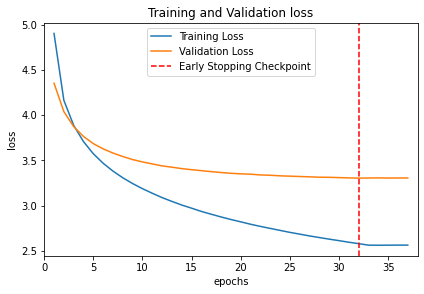

In [49]:
# epoch = range(num_epochs)
# fig, ax = plt.subplots()
# plt.plot(epoch, train_losses, 'g', label='Training loss')
# plt.plot(epoch, val_losses, 'b', label='Validation loss')
# plt.title('Training and Validation loss')
# plt.xlabel('Epochs')
# ax.set_xticks(epoch)
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

 # visualize the loss as the network trained
fig = plt.figure()
plt.plot(range(1,len(train_losses)+1),train_losses, label='Training Loss')
plt.plot(range(1,len(val_losses)+1),val_losses,label='Validation Loss')

# find position of lowest validation loss
minposs = val_losses.index(min(val_losses))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
#plt.ylim(1, 5) # consistent scale
plt.xlim(0, len(train_losses)+1) # consistent scale
#plt.grid(True)
plt.legend()
plt.tight_layout()
plt.title('Training and Validation loss')
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

In [50]:
def translate_dev(i):
    text = " ".join([int_to_vocab[w] for w in text_val[i]])
    print(text)
    summary = " ".join([int_to_vocab[w] for w in summ_val[i]])
    print(summary)

    mb_x = torch.from_numpy(np.array(text_val[i]).reshape(1,-1)).long().to(device)
    mb_x_len = torch.from_numpy(np.array([len(text_val[i])])).long().to(device)
    # mb_y = torch.from_numpy(summ_val[i].reshape(1,-1)).long().to(device)
    # mb_y_len = torch.from_numpy([len(summ_val[i])]).long().to(device)
    bos = torch.Tensor([[vocab_to_int["<GO>"]]]).long().to(device)
    # 翻译时decoder的输入序列bos： [<GO>的index] 
    translation, attn = model.translate(mb_x,mb_x_len, bos)
    translation = [int_to_vocab[i] for i in translation.data.cpu().numpy().reshape(-1)]
    trans = []
    for word in translation:
        if word !="<EOS>":
            trans.append(word)
        else:
            break
    print(" ".join(trans))
    

In [51]:
for i in range(110,130):
    translate_dev(i)
    print()

<GO> chihuahua since puppy never much appetite tried varieties dry canned dog food would barely sniff underweight result coat looked terrible glad discover dog food thing eat since began feeding lamb gained whole pound coat thicker longer also eats wellness dry really cannot say enough good things brand dog food also works chihuahua huge appetite severe food allergies <br ><br >if nothing else worked give try may surprised much dog loves <EOS>
<GO> this is the only food my dog will eat <EOS>
my dog loves it

<GO> absolute favorite yogi tea pleasantly spicy hint rich chocolate much prefer mayan cocoa spice sweet thai flavors reach get craving cup hot chocolate want calories <EOS>
<GO> great warming flavor on a dreary day <EOS>
hot cocoa

<GO> found sharp raw product works well difficult combine ingredients chocolate overpowering tried infusing herbs spices none showed chocolate tight composed earthy tones somehow anything add serves bring chocolate textures flavor found hard tone much l

In [52]:
translate_dev(250)

<GO> really nice almond flour fine like says dark pieces skins like flours use bake macarons great texture color two pack sure buying soon <EOS>
<GO> great for macarons <EOS>
nice and tasty


In [53]:
#torch.save(model.state_dict(), '\\Users\\SWong7923\\PycharmProjects\\pythonProject2\\model\\checkpoint.pt'

In [54]:
model.load_state_dict(torch.load('\\Users\\SWong7923\\PycharmProjects\\pythonProject2\\checkpoint.pt'))